#### The Neural N Population Oscillator with Periodic Perturbation
## Model

The model of N coupled population oscillators is described by the following first-order nonlinear differential equations:

$$ \frac{d(Ex_{i})}{dt} = h_{ex} - dist_i - Ex_{i} + c_1*sigmoid(Ex_{i}) - c_2*sigmoid(In_{i}) + cs* coupling_{i} + pert_k $$
$$ \frac{d(In_{i})}{dt} \,\, = h_{in} \,\, - In_{i} \, + c_3*sigmoid(Ex_{i}) - c_4*sigmoid(In_{i})) $$

$Ex_{i}$ and $In_{i}$ are the excitatory and inhibitory population at location _i_ where $i = 1, 2, \ldots N$ and $N$ is the nunmber of oscillators.

$h_{ex}$, $h_{in}$, $c_1$, $c_2$, $c_3$ and $c_4$ are model parameters representing constant input ($h_i$) and strength of (self-)coupling ($c_j$), respectively. 

Function _sigmoid_ is the (nonlinear) tangens hyperbolicus.

$dist$ is a parameter that sets the distance of the model from the homoclinic bifurcation (see Figure 3). $dist = 0$ for $i=1$, $dist = 0.15$ for $i=2$, and $dist = 0.30$ for all other oscillators. It is based on the observation that oscillator 1 represents the seizure onset location, oscillator 2 the immediate neighbour to it (immediate spreading), and all other locations represent areas that are not involved in seizure activity with the first 20 seconds. 

$coupling_{i}$ is sum over the i-th row of the symmetric $N\times N$ coupling matrix with diagonal elements equal to zero. The off-diagonal elements are obtained from the phase lock matrix of the sEEG in a 90 second interval leading up to the seizure (i.e. no seizure activity). The strength of the coupling is adjusted by the coupling constant $cs$.

$pert_k$ is the pulse perturbation protocol to simulate external stimulation applied to oscillator $k$.


# Imports

In [1]:
from pandas import read_csv, DataFrame

import scipy.signal as signal

from scipy.integrate import odeint

import json

from matplotlib.pyplot import subplots, xticks, yticks, axis, figure

from numpy import arange, gradient, linspace, mod, tanh, var, asarray, around
from numpy import loadtxt, asarray, linspace, flip, arange, zeros, angle, unwrap, exp
from numpy import flip, zeros, ones, sqrt, where, max, min, angle, unwrap
from numpy import fill_diagonal, repeat, hstack, ndarray, corrcoef, exp

from numpy.random import default_rng

import sk_dsp_comm.sigsys as ss

from itertools import product


# Function Definitions

In [2]:
def filter_eeg(data, filter_settings, sr):

    import scipy.signal as signal
    from numpy import zeros

    rows  = data.shape[0]
    chans = data.shape[1] 

    sos = signal.butter(filter_settings[0], (filter_settings[1], filter_settings[2]), btype='bandpass', fs=sr, output='sos')

    data_filtered = zeros((rows, chans))

    for index, column in enumerate(data.transpose()): 
        forward = signal.sosfilt(sos, column)
        backwards = signal.sosfilt(sos, forward[-1::-1])
        data_filtered[:, index] = backwards[-1::-1]
        
    return data_filtered


In [3]:
def sigmoid(u):
    return tanh(u)

def N_oscillators(y, t, N, h_ex_rand, h_in_rand, coupling_matrix, pars, flag, pert_osc, h_ex_p, sr, time_steps):

    # Parameters
    tau_ex, tau_in, c1, c2, c3, c4 = pars

    h_ex_index = int(t*sr)
    
    if h_ex_index >= time_steps:

        dydt = zeros(2*N)
        
        return dydt


    if  N == 1:

        h_ex = h_ex1_0

        dydt = (
                (h_ex_rand[osc] - y[0] + c1*sigmoid(y[0]) - c2*sigmoid(y[1]))*tau_ex,
                (h_in_rand[osc] - y[1] + c3*sigmoid(y[0]) - c4*sigmoid(y[1]))*tau_in
        )

        
    else:
        # Separate Variables
        y_ex = y[:-1:2]
        y_in = y[1::2]

        dy_ex, dy_in = zeros(N), zeros(N)
        dydt = zeros(2*N)

        for osc in arange(N):
            
            coup = sum(coupling_matrix[:, osc] * y_ex) / (N-1)

            if osc == pert_osc:

                dy_ex[osc] = (h_ex_p[h_ex_index] - y_ex[osc] + c1*sigmoid(y_ex[osc]) - c2*sigmoid(y_in[osc]) + coup)*tau_ex 

                dy_in[osc] = (h_in_rand[osc]     - y_in[osc] + c3*sigmoid(y_ex[osc]) - c4*sigmoid(y_in[osc])       )*tau_in

            else:
            
                if flag[osc] == 0:    # Onset
                    
                    h_ex = h_ex_rand[osc]
    
                    dy_ex[osc] = (h_ex           - y_ex[osc] + c1*sigmoid(y_ex[osc]) - c2*sigmoid(y_in[osc]) + coup)*tau_ex 
                    dy_in[osc] = (h_in_rand[osc] - y_in[osc] + c3*sigmoid(y_ex[osc]) - c4*sigmoid(y_in[osc])       )*tau_in
    
                elif flag[osc] == 1:    # Propagation
                
                    h_ex = h_ex_rand[osc]     - 0.10
    
                    dy_ex[osc] = (h_ex           - y_ex[osc] + c1*sigmoid(y_ex[osc]) - c2*sigmoid(y_in[osc]) + coup)*tau_ex 
                    dy_in[osc] = (h_in_rand[osc] - y_in[osc] + c3*sigmoid(y_ex[osc]) - c4*sigmoid(y_in[osc])        )*tau_in
    
                elif flag[osc] == 2:    # Passive tissue
                
                    h_ex = h_ex_rand[osc]     - 0.20
    
                    dy_ex[osc] = (h_ex           - y_ex[osc] + c1*sigmoid(y_ex[osc]) - c2*sigmoid(y_in[osc]) + coup)*tau_ex 
                    dy_in[osc] = (h_in_rand[osc] - y_in[osc] + c3*sigmoid(y_ex[osc]) - c4*sigmoid(y_in[osc])        )*tau_in
                    
    # Combine Variables

        dydt[:-1:2] = dy_ex
        dydt[1: :2] = dy_in


    return dydt


In [4]:
def N_oscillators_plus_driving(y, t, N, h_ex_rand, h_in_rand, coupling_matrix, pars, sr, time_stop, driving, driving_strength):

    tau_ex, tau_in, c1, c2, c3, c4 = pars
    
    t_index = int(t*sr)
    
    if t_index >= time_stop*sr:

        dydt = zeros(2*N)
        
        return dydt

    if  N == 1:

        h_ex_rand_driven = h_ex_rand + driving_strength*driving[noise_index]

        dydt = (
            (h_ex_rand_driven - y[0] + c1*sigmoid(y[0]) - c2*sigmoid(y[1]) + random_strength*random_data[noise_index])*tau_ex,
            (h_in             - y[1] + c3*sigmoid(y[0]) - c4*sigmoid(y[0])                                                                 )*tau_in,
       )
        
    else:

        coup_matrix_scaled = coupling_matrix / (N-1)
        
        # Separate Variables
        y_ex = y[:-1:2]
        y_in = y[1::2]

        dy_ex, dy_in = zeros(N), zeros(N)
        dydt = zeros(2*N)

        for osc in arange(N):
            
            coup = sum(coup_matrix_scaled[:, osc] * y_ex)

            h_ex_rand_driven = h_ex_rand[osc] + driving_strength*driving[t_index]
                
            dy_ex[osc] = (h_ex_rand_driven - y_ex[osc] + c1*sigmoid(y_ex[osc]) - c2*sigmoid(y_in[osc]) + coup)*tau_ex 
            dy_in[osc] = (h_in_rand[osc]   - y_in[osc] + c3*sigmoid(y_ex[osc]) - c4*sigmoid(y_in[osc])        )*tau_in

        dydt[:-1:2] = dy_ex
        dydt[1: :2] = dy_in

    return dydt

In [5]:
def plot_series(time, data, time_stop, sr):

    name_vars = ('Ex', 'In')
    
    no_vars = len(name_vars)
    
    N = data.shape[1]//no_vars

    if N == 1:
    
        fig, ax = subplots(ncols=len(name_vars), figsize=(10, 6))
        
        for ind in arange(no_vars):
            
            ax[ind].plot(time, y[:, ind], linewidth=2, c='b')
            ax[ind].set_xticks(linspace(0, time_stop, 5));
            ax[ind].set_xticklabels([]);
            ax[ind].set_xlabel('Time', fontsize=14);
            ax[ind].set_ylabel(name_vars[ind], fontsize=14)
            y_min, y_max = ax[ind].get_ylim()
            ax[ind].set_yticks(linspace(y_min, y_max, 3));
            ax[ind].set_yticklabels(around(linspace(y_min, y_max, 3),1), fontsize=14);
    
    else:
        
        y_max1 = max(data[:,::2])
        y_min1 = min(data[:,::2])

        y_max1_ax = y_max1 + 0.1*(y_max1-y_min1)
        y_min1_ax = y_min1 - 0.1*(y_max1-y_min1)

        y_max2 = max(data[:,1::2])
        y_min2 = min(data[:,1::2])

        y_max2_ax = y_max2 + 0.1*(y_max2-y_min2)
        y_min2_ax = y_min2 - 0.1*(y_max2-y_min2)
    
        
        fig, ax = subplots(ncols=no_vars, nrows=N, figsize=(10, 6))
        
        for osc in arange(N):
            for ind in arange(no_vars):
                
                if ind == 0:
                    ax[osc, ind].plot(time, data[:, 2*osc+ind], linewidth=2, c='b')
                    ax[osc, ind].set_xticklabels([]);
                    ax[osc, ind].set_ylim(y_min1_ax, y_max1_ax)   
                    ax[osc, ind].set_yticks(linspace(y_min1_ax, y_max1_ax, 3));
                    ax[osc, ind].set_yticklabels(around(linspace(y_min1_ax, y_max1_ax, 3),1), fontsize=14);
    
                elif ind == 1:
                    ax[osc, ind].plot(time, data[:, 2*osc+ind], linewidth=2, c='r')
                    ax[osc, ind].set_xticklabels([]);
                    ax[osc, ind].set_ylim(y_min2_ax, y_max2_ax)
                    ax[osc, ind].set_yticks(linspace(y_min2_ax, y_max2_ax, 3));
                    ax[osc, ind].set_yticklabels(around(linspace(y_min2_ax, y_max2_ax, 3),1), fontsize=14);
                    
                if osc == N-1:
                    
                    ax[N-1, ind].set_xlabel('Time', fontsize=14);
                    ax[N-1, ind].set_xticks(linspace(0, time_stop, 5));
                    ax[N-1, ind].set_xticklabels(around(linspace(0, time_stop/sr, 5), 2));
    
                label_text = name_vars[ind] + str(osc+1)
    
                ax[osc, ind].set_ylabel(label_text, fontsize=14)
                      
    fig.tight_layout()
    
    return fig, ax
    

In [6]:
def phase_lock(data, sr):
    
    # sos = butter(order, (params[0],params[1]), btype='bandpass', fs=sr, output='sos')

    rows     = data.shape[0]
    channels = data.shape[1]
    
    time_end = int(rows / sr)
    time     = linspace(0, time_end, rows)

    signal_phases = zeros((len(time), channels))

    for index, column in enumerate(data.transpose()):
    
        instantaneous_phase = angle(signal.hilbert(column))
        inst_phase_unwrap   = unwrap(instantaneous_phase)
        signal_phases[:, index] = inst_phase_unwrap
    
    phase_lock_mat = zeros((channels, channels))

    for index1, column in enumerate(signal_phases.transpose()):
        for index2 in arange(index1+1, channels):
              
            phase_diff = column - signal_phases[:, index2]
            phase_lock_mat[index1, index2] = abs(sum(exp(-1j*phase_diff)))/phase_diff.size

    return phase_lock_mat


# EEG Data

Tumour_2017linzhijing

FCD_II_2019zhangpeiyao

HS_2019zhengyaqi

FCD_II_2019xingshuo

FCD_II_2018wangli

HS_2018wuzhisen


In [7]:
# Read data from csv
patient = 'HS_2018wuzhisen' # This patient has hippocampal sclerosis and mTLE seizures

# path = '/Users/nikhita/Dropbox/Seizure_Onset_B_slow.csv'
path = '/Users/geroldbaier/Library/CloudStorage/Dropbox/EEG/EEG_Data/' + patient + '/Series/Seizure_Onset_B_slow.csv'
df = read_csv(path, sep=' ', header=None)

data_np = df.to_numpy()

data = data_np[:, :]

sr = 1000

all_labels_list = []

label_path = '/Users/geroldbaier/Library/CloudStorage/Dropbox/EEG/EEG_Data/' + patient + '/Series/All_onsets_labels_B.txt'
# label_path = '/Users/nikhita/Dropbox/All_onsets_labels_B.txt'

with open(label_path, 'r') as file:
    
    for line in file:

        label = line[:-1]
        all_labels_list.append(label)

rows, chans = data.shape

chan_select = chans

if chan_select > len(all_labels_list):

    print('not enough EEG time series')

else:
    
    chan_names = all_labels_list[:chan_select]

patient, rows, chans, chan_names

('HS_2018wuzhisen',
 180000,
 11,
 ['B1-B2',
  'B2-B3',
  'B3-B4',
  'B4-B5',
  'B5-B6',
  'B6-B7',
  'B7-B8',
  'B8-B9',
  'B9-B10',
  'B10-B11',
  'B11-B12'])

In [8]:
sr = 1000

sample_start = 0  
sample_end   = sample_start + rows

order, low, high = 5, 1, 12

filter_settings = [order, low, high]

data_filtered = filter_eeg(data, filter_settings, sr)

data_filtered.shape


(180000, 11)

## Display Electrode

'Figs/Fig_1/Fig_1C.png'

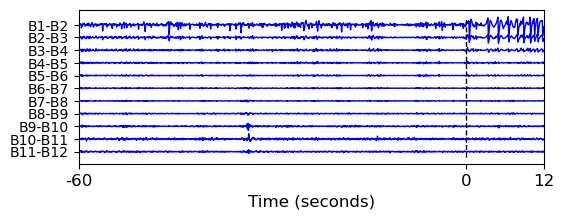

In [9]:
elec = 'B'

data_elec = data_filtered

segment = 0

onset_time = 97.5

seconds_pre, seconds_ict = 60, 12

start = int(onset_time*sr) - seconds_pre*sr
stop  = int(onset_time*sr) + seconds_ict*sr

offset = 500

vmin, vmax = -100, 100

###################################################
fig, ax = subplots(figsize=(6, 2))

ax.plot(data_elec[start:stop, :chan_select] + offset*arange(chan_select-1,-1,-1), 
        linewidth=1, color='b');

ax.set_yticks(offset*arange(chan_select))
ax.set_yticklabels(flip(arange(chan_select)))
ax.margins(x=0)
ax.set_xticks((0, seconds_pre*sr, (seconds_pre + seconds_ict)*sr-1))
labl = (-seconds_pre, 0, seconds_ict)
ax.set_xticklabels(labl, fontsize=12)
ax.set_yticks(offset*arange(len(chan_names)));
ax.set_yticklabels(flip(chan_names));
ax.vlines(onset_time*sr-start, -200, 5300, color="k", 
          linestyles='dashed', linewidth=1);
ax.set_xlabel('Time (seconds)', fontsize=12);

title_chars = 'Figs/Fig_1/Fig_1C.png'

# fig.savefig(title_chars, dpi=300, format='png', bbox_inches='tight')
title_chars


# Figure 1 Caption:

Figure 1A | Exemplar SEEG electrode implantation. (a) A slice of co-registered CT and MRI image. White dashed lines indicate the implanted depth electrodes. (b) Electrodes (indicated by dark pins) depicted in a three-dimensional brain model. Each electrode contains multiple contacts along its length, illustrated schematically by the four blue dots (named with 1-4) located in one of the electrodes. Figure adapted from a study by Li G. et al.19.

Figure 1B | Schematic diagram of an electrode with six contacts (top) and the connectivity within and between the underlying neural populations associated with the contacts (below). Black areas on the electrode depict each contact. E1-E5 denote the excitatory populations and I1-I5 denote the inhibitory populations. This figure depicts how excitation spreads within one oscillator as well as between neighbouring oscillators. The black arrows indicate excitation (with arrowhead) and inhibition (rectangular block) within an oscillator. Red arrows represent excitatory connections between neighbouring excitatory populations. Green arrows (H_E1 - H_E5) represent constant input to excitatory populations. Blue arrows (H_I1 - H_I5) represent constant input to inhibitory populations.

Figure 1C | Time series of sEEG from the body of the hippocampus in bipolar montage. Clinically annotated seizure onset marked as “0”.  

## Correlation Matrix

In [10]:
# rows_select = rows // 2

# data_select = data_filtered[:rows_select, :chan_select]

# data_corr = corrcoef(data_select, rowvar=False)

# fill_diagonal(data_corr, 0)

# data_corr_abs = abs(data_corr)


# fig = figure(constrained_layout=True, figsize=(8,2))

# gs  = fig.add_gridspec(1, 4)

# ax1 = fig.add_subplot(gs[:3])

# offset  = 10

# dataset = data_select
# means   = data_select.mean(axis=0)
# devs    = data_select.std(axis=0)

# ax1.plot((dataset - means)/devs + offset*arange(chan_select-1,-1,-1), linewidth=1, color='b');
# ax1.plot(zeros((rows_select, chan_select)) + offset*arange(chan_select-1,-1,-1),'--',color='gray');
# ax1.set(ylabel='Voltage')


# ax2 = fig.add_subplot(gs[3])
# im = ax2.imshow(data_corr_abs, cmap='bwr', vmax=1);
# fig.colorbar(im, ax=ax2, ticks=(0, 0.5, 1), shrink = 0.8);

# time_long = 20

# ax1.set_xticks(linspace(0, rows_select-1, 5))
# labl = linspace(0, rows_select/sr, 5)
# ax1.set_xticklabels(labl, fontsize=12)
# ax1.set_xlabel('Time (seconds)', fontsize=12)

# ax1.set_ylabel('Voltage', fontsize=12)
# # ax1.axvline(x=rows//2, ymin=0.05, ymax=0.95, linewidth=2, color='k', linestyle='--')

# title_chars = 'figs/homoclinic_EEG_corr_B14.16.17_corrs.png'
# # fig.savefig(title_chars, format='png')
# print(title_chars)


## Phase Locking Matrix

figs/homoclinic_EEG_corr_B_corrs.png


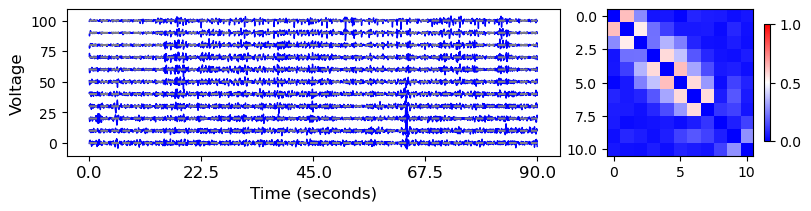

In [11]:
rows_select = rows // 2

data_select = data_filtered[:rows_select, :chan_select]

phase_lock_mat = phase_lock(data_select, sr)

phase_lock_mat_full = phase_lock_mat + phase_lock_mat.T

fig = figure(constrained_layout=True, figsize=(8,2))

gs  = fig.add_gridspec(1, 4)

ax1 = fig.add_subplot(gs[:3])

offset  = 10

dataset = data_select
means   = data_select.mean(axis=0)
devs    = data_select.std(axis=0)

ax1.plot((dataset - means)/devs + offset*arange(chan_select-1,-1,-1), linewidth=1, color='b');
ax1.plot(zeros((rows_select, chan_select)) + offset*arange(chan_select-1,-1,-1),'--',color='gray');
ax1.set(ylabel='Voltage')


ax2 = fig.add_subplot(gs[3])
im = ax2.imshow(phase_lock_mat_full, cmap='bwr', vmax=1);
fig.colorbar(im, ax=ax2, ticks=(0, 0.5, 1), shrink = 0.8);

time_long = 20

ax1.set_xticks(linspace(0, rows_select-1, 5))
labl = linspace(0, rows_select/sr, 5)
ax1.set_xticklabels(labl, fontsize=12)
ax1.set_xlabel('Time (seconds)', fontsize=12)

ax1.set_ylabel('Voltage', fontsize=12)
# ax1.axvline(x=rows//2, ymin=0.05, ymax=0.95, linewidth=2, color='k', linestyle='--')

title_chars = 'figs/homoclinic_EEG_corr_B_corrs.png'
# fig.savefig(title_chars, format='png')
print(title_chars)

# N Oscillator Model
## Time Series

In [12]:
# Number of oscillators > 2
N = 5

# Input parameters
h_ex_0    = -1.37
h_in_0    = -4.0

eps  = 0.00001

SEED = 12345

rng = default_rng(SEED)

h_ex_rand = h_ex_0 + eps*rng.normal(0,1,size=N)
h_in_rand = h_in_0 + eps*rng.normal(0,1,size=N)

# Homoclinic / SNIC parameters
pars = (1, 1, 4, 4, 10, 0) # HC t_in = 2; SNIC t_in = 1


# Onset flag
flag     = zeros(N)
flag[1]  = 1
flag[2:] = 2

flag = [int(item) for item in flag]

print(flag)

if len(flag) != N:
    
    print('Warning: Number of items in Onset Flag not equal to N')

if N == 1:
    
    # Coupling matrix
    coupling_strength = 0
    coupling_matrix = 0

    # Initial conditions
    y_ini = rng.uniform(size=2*N)
    # y_ini = y[-1, :]


else:

    coupling_strength = 1.0

    ## Phase Locking Matrix
    coupling_matrix = coupling_strength * phase_lock_mat_full[:N, :N]

    SEED_2 = 123

    rng = default_rng(SEED_2)
    
    # Initial conditions
    y_ini = rng.uniform(size=2*N)*10

    # y_ini = y[-1, :]

sr = 1000
    
# Stop time and time array
time_stop = 50
sr        = 1000
time      = linspace(start=0, stop=time_stop, num=time_stop*sr)
time_steps  = time_stop*sr

pert_osc = -1

h_ex_p = 0


# Simulation
y = odeint(func=N_oscillators, y0=y_ini, t=time, 
           args=(N, h_ex_rand, h_in_rand, coupling_matrix, pars, flag, pert_osc, h_ex_p, sr, time_steps), hmax=0.1)

# Show final values of all variables
print('End of run:', list(around(y[-1,:], 2)))


[0, 1, 2, 2, 2]
End of run: [-1.46, -12.97, -2.0, -13.64, -2.1, -13.7, -1.93, -13.58, -1.95, -13.6]


Figures/SNIC_timeseries_coup_1.0.png


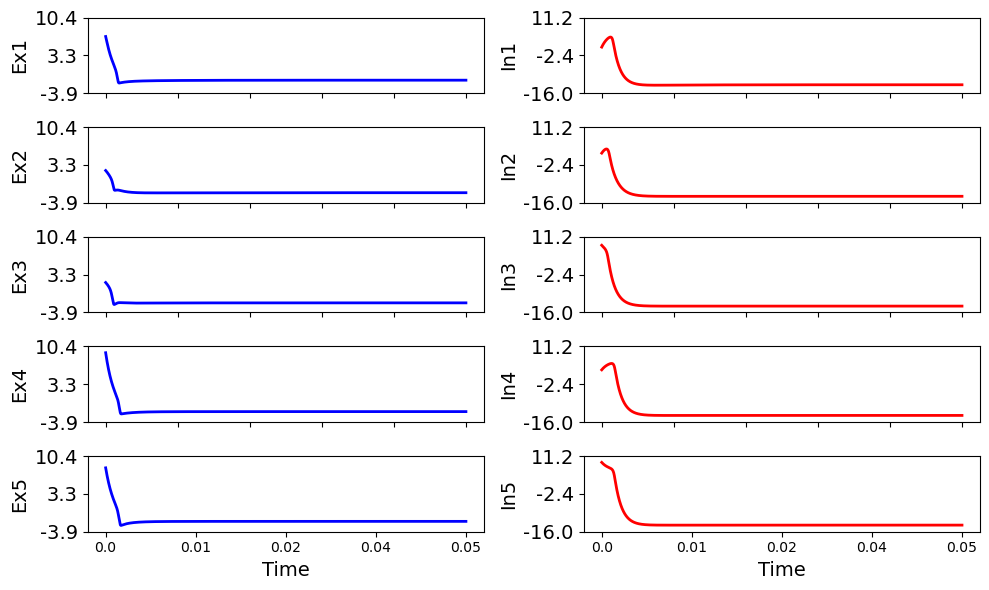

In [13]:
# Plot
fig, ax = plot_series(time, y, time_stop, sr)

title_chars = 'Figures/SNIC_timeseries_coup_' + str(coupling_strength) + '.png'
# fig.savefig(title_chars, format='png')
print(title_chars)

In [14]:
# Update
y_ini = y[-1,:]

# Show final values of all variables
print('End of run:', list(around(y[-1,:],3)))

End of run: [-1.456, -12.969, -2.002, -13.642, -2.098, -13.704, -1.927, -13.585, -1.95, -13.603]


## Onset Simulation

In [15]:
# if N == 1:
    
#     coupling_strength_E, coupling_strength_I = 0, 0
#     coupling_matrix_E,   coupling_matrix_I   = 0, 0

# else:

#     # coupling_strength = 0.1
#     coupling_matrix = coupling_strength * phase_lock_mat_full
    
# IC_state = 'OK'

# # seed(1112)

# if IC_state   == 'SY':
    
#     # y_ini = uniform(size=2*N)
#     y_ini = rng.uniform(size=2*N)

# else:
    
#     y_ini = y[-1, :]


# # Time array
# time_stop = 600
# sr        = 100
# time      = linspace(start=0, stop=time_stop, num=time_stop*sr)

# # Driving

# driving = linspace(0, 1, time.size)

# driving_strength = 1.0

# # Simulation
# y = odeint(func=N_oscillators_plus_driving, y0=y_ini, t=time, 
#           args=(N, h_ex_rand, h_in_rand, coupling_matrix, pars,
#                 sr, time_stop, driving, driving_strength), hmax=0.1)

# # y_unfiltered = y[:,::2, :]

# print('End of run:', y.shape)
# print('')


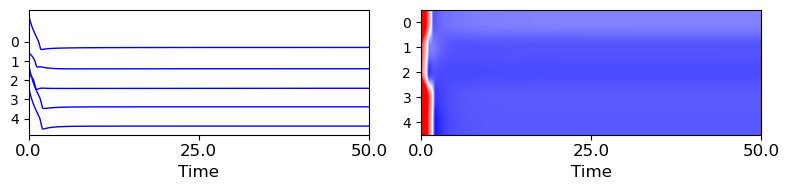

In [16]:
start, stop = 0, y.shape[0]

offset = 5

vmin, vmax = -3, 3

###################################################
fig, ax = subplots(nrows=1, ncols=2, figsize=(8, 2))

ax[0].plot(y[start:stop, ::2] + offset*arange(N-1,-1,-1), 
        linewidth=1, color='b');
# ax[0, 1].plot(y_unfiltered[start:stop, :, 1] + offset*arange(N-1,-1,-1), 
#         linewidth=1, color='b');

ax[0].set_yticks(offset*arange(N))
ax[0].set_yticklabels(flip(arange(N)))
ax[0].margins(x=0)
ax[0].set_xticks(linspace(0, stop-start, 3))
labl = linspace(start/sr, stop/sr, 3)
ax[0].set_xticklabels(labl, fontsize=12)
# ax[0].set_title('Without Cross-Inhibition')
ax[0].set_xlabel('Time', fontsize=12)


ax[1].imshow(y[start:stop, ::2].T, aspect='auto', 
          cmap='bwr', vmin=vmin, vmax=vmax);
# ax[1, 1].imshow(y_unfiltered[start:stop, :, 1].T, aspect='auto', 
#           cmap='bwr', vmin=vmin, vmax=vmax);

ax[1].set_xticks(linspace(0, stop-start, 3))
labl = linspace(start/sr, stop/sr, 3)
ax[1].set_xticklabels(labl, fontsize=12)
ax[1].set_xlabel('Time', fontsize=12)
ax[1].set_yticks(arange(y.shape[1]//2));
ax[1].set_yticklabels(arange(y.shape[1]//2));

fig.tight_layout()


## Bifurcation Diagram

In [47]:
if N == 1:

    # Initial conditions
    y_ini = uniform(size=2*N)

else:

    # Initial conditions
    # y_ini = uniform(size=2*N)
    y_ini = y[-1, :]
    
# Parameter range
h_ex_sta = -1.6
h_ex_end = -1.2

eps  = 0.00001

SEED = 111

resolution = 30

h_vals = linspace(h_ex_sta, h_ex_end, resolution)

# Stop time and time array
time_stop = 300
time = linspace(start=0, stop=time_stop, num=time_stop*sr)

results_max_f      = dict()
results_max_inds_f = dict()
results_min_f      = dict()
results_min_inds_f = dict()

# Simulation "forward"
for h_val in h_vals:

    rng = default_rng(SEED)

    h_ex_rand = h_val + eps*rng.normal(0, 1, size=N)
    
    y_f = odeint(func=N_oscillators, y0=y_ini, t=time, 
             args=(N, h_ex_rand, h_in_rand, coupling_matrix, pars, flag, pert_osc, h_ex_p, sr, time_steps), hmax=0.1)
  
    rows = y.shape[0]

    for num, series in enumerate(y_f[rows//2:,:-1:2].T):
                
        if var(series) < 0.1:
            
            if num not in results_max_f:
                
                results_max_f[num]      = [series[-1]]
                results_max_inds_f[num] = [0]    
                results_min_f[num]      = [series[-1]]
                results_min_inds_f[num] = [0]    
                
            else:
                results_max_f[num].append(series[-1])
                results_max_inds_f[num].append(0)    
                results_min_f[num].append(series[-1])
                results_min_inds_f[num].append(0)               


        else:
            y_f_max_inds = signal.find_peaks(series, distance=100)
            y_f_maxs     = series[y_f_max_inds[0]]

            y_f_min_inds = signal.find_peaks(-series, distance=100)
            y_f_mins     = series[y_f_min_inds[0]]

            if num not in results_max_f:

                results_max_f[num]      = [y_f_maxs]
                results_max_inds_f[num] = [y_f_max_inds]
                results_min_f[num]      = [y_f_mins]    
                results_min_inds_f[num] = [y_f_min_inds]    

            else:

                results_max_f[num].append(y_f_maxs)
                results_max_inds_f[num].append(y_f_max_inds)
                results_min_f[num].append(y_f_mins)
                results_min_inds_f[num].append(y_f_min_inds)

    y_ini = y_f[-1, :]


results_max_b      = dict()
results_max_inds_b = dict()
results_min_b      = dict()
results_min_inds_b = dict()

# Simulation "backward"
for h_val in flip(h_vals):

    rng = default_rng(SEED)

    h_ex_rand = h_val + eps*rng.normal(0, 1, size=N)
    
    y_b = odeint(func=N_oscillators, y0=y_ini, t=time, 
             args=(N, h_ex_rand, h_in_rand, coupling_matrix, pars, flag, pert_osc, h_ex_p, sr, time_steps), hmax=0.1)


    rows = y_b.shape[0]

    
    for num, series in enumerate(y_b[rows//2:,:-1:2].T):
        
        if var(series) < 0.1:
            
            if num not in results_max_b:
                
                results_max_b[num]      = [series[-1]]
                results_max_inds_b[num] = [0]    
                results_min_b[num]      = [series[-1]]
                results_min_inds_b[num] = [0]    
                
            else:
                results_max_b[num].append(series[-1])
                results_max_inds_b[num].append(0)    
                results_min_b[num].append(series[-1])
                results_min_inds_b[num].append(0)               


        else:
            y_b_max_inds = signal.find_peaks(series, distance=100)
            y_b_maxs     = series[y_b_max_inds[0]]

            y_b_min_inds = signal.find_peaks(-series, distance=100)
            y_b_mins     = series[y_b_min_inds[0]]

            if num not in results_max_b:

                results_max_b[num]      = [y_b_maxs]
                results_max_inds_b[num] = [y_b_max_inds]
                results_min_b[num]      = [y_b_mins]    
                results_min_inds_b[num] = [y_b_min_inds]    

            else:

                results_max_b[num].append(y_b_maxs)
                results_max_inds_b[num].append(y_b_max_inds)
                results_min_b[num].append(y_b_mins)
                results_min_inds_b[num].append(y_b_min_inds)

    y_ini = y_b[-1, :]

print('Scan complete!', list(around(y_b[-1,:],3)))


Scan complete! [-2.108, -13.709, -2.531, -13.874, -2.582, -13.886, -2.384, -13.832, -2.406, -13.839]


'figs/SNIC_bifs_coup_1.0.png'

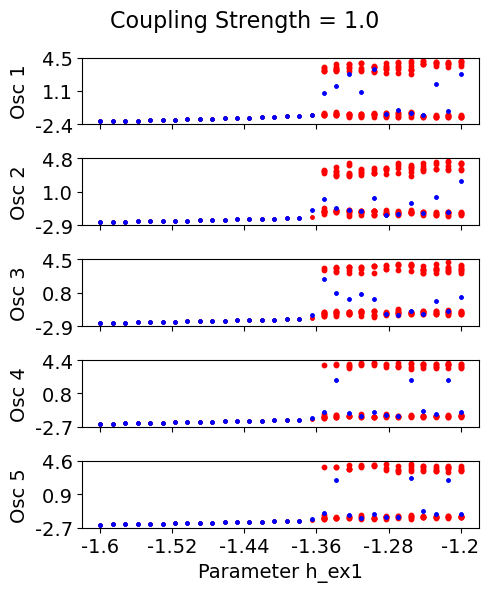

In [48]:
# Plot

if N == 1:

    fig, ax = subplots()

    for xe, ye in zip(h_vals, results_max_f[0]):

        if not isinstance(ye, ndarray):
            ax.scatter(xe, ye, c='r', s=5)
        else:
            ax.scatter([xe] * len(ye), ye, s=10, marker='x', facecolors='none', edgecolors='r')

    for xe, ye in zip(h_vals, results_min_f[0]):

        if not isinstance(ye, ndarray):
            ax.scatter(xe, ye, c='r', s=5)
        else:
            ax.scatter([xe] * len(ye), ye, s=10, marker='x', facecolors='none', edgecolors='r')

    for xe, ye in zip(flip(h_vals), results_max_b[0]):

        if not isinstance(ye, ndarray):
            ax.scatter(xe, ye, c='r', s=5)
        else:
            ax.scatter([xe] * len(ye), ye, c='b', s=10, marker='P')

    for xe, ye in zip(flip(h_vals), results_min_b[0]):

        if not isinstance(ye, ndarray):
            ax.scatter(xe, ye, c='r', s=5)
        else:
            ax.scatter([xe] * len(ye), ye, c='b', s=10, marker='P')

    ax.set_xticks(linspace(h_ex_sta, h_ex_end, 5));
    ax.set_xticklabels(around(linspace(h_ex_sta, h_ex_end, 5), 2), fontsize=16);
    ax.set_xlabel('Parameter h_ex1', fontsize=16)

    ax.set_ylabel('EX', fontsize=14)

    y_min, y_max = ax.get_ylim()

    ax.set_yticks(linspace(y_min, y_max, 3));
    ax.set_yticklabels(around(linspace(y_min, y_max, 3),1), fontsize=14);

    
else:

    fig, ax = subplots(ncols=1, nrows=N, figsize=(5, 6))
    
    for osc in arange(N):
        
        # Forward
        for xe, ye in zip(h_vals, results_max_f[osc]):

            if not isinstance(ye, ndarray):
                ax[osc].scatter(xe, ye, c='r', s=5)
            else:
                ax[osc].scatter([xe] * len(ye), ye, s=10, marker='o', facecolors='r')

        for xe, ye in zip(h_vals, results_min_f[osc]):

            if not isinstance(ye, ndarray):
                ax[osc].scatter(xe, ye, c='r', s=5)
            else:
                ax[osc].scatter([xe] * len(ye), ye, s=10, marker='o', facecolors='r')


        # Backward
        for xe, ye in zip(flip(h_vals), results_max_b[osc]):

            if not isinstance(ye, ndarray):
                ax[osc].scatter(xe, ye, c='b', s=5)
            else:
                ax[osc].scatter([xe] * len(ye), ye, c='m', s=10, marker='P')

        for xe, ye in zip(flip(h_vals), results_min_b[osc]):

            if not isinstance(ye, ndarray):
                ax[osc].scatter(xe, ye, c='b', s=5)
            else:
                ax[osc].scatter([xe] * len(ye), ye, c='m', s=10, marker='P')

        ax[osc].set_xticks(linspace(h_ex_sta, h_ex_end, 6))
        ax[osc].set_xticklabels([])
        
        y_min, y_max = ax[osc].get_ylim()

        ax[osc].set_yticks(linspace(y_min, y_max, 3));
        ax[osc].set_yticklabels(around(linspace(y_min, y_max, 3),1), fontsize=14);

        label_text = 'Osc ' + str(osc+1)
        ax[osc].set_ylabel(label_text, fontsize=14)

    ax[osc].set_xticks(linspace(h_ex_sta, h_ex_end, 6));
    ax[osc].set_xticklabels(around(linspace(h_ex_sta, h_ex_end, 6), 2), fontsize=14);
    ax[osc].set_xlabel('Parameter h_ex1', fontsize=14)

title_chars = 'Coupling Strength = ' + str(coupling_strength)
fig.suptitle(title_chars, fontsize=16)

fig.tight_layout()


title_chars = 'figs/SNIC_bifs_coup_' + str(coupling_strength) + '.png'
# fig.savefig(title_chars, format='png')
title_chars


## Reset initial conditions

In [17]:
# Simulation
y = odeint(func=N_oscillators, y0=y_ini, t=time, 
           args=(N, h_ex_rand, h_in_rand, coupling_matrix, pars, flag, pert_osc, h_ex_p, sr, time_steps), hmax=0.1)

# Update
y_ini = y[-1,:]

# Show final values of all variables
print('End of run:', list(around(y[-1,:], 2)))

h_ex_rand


End of run: [-1.46, -12.97, -2.0, -13.64, -2.1, -13.7, -1.93, -13.58, -1.95, -13.6]


array([-1.37001424, -1.36998736, -1.37000871, -1.37000259, -1.37000075])

## Scan Frequency

(30, 30, 5)

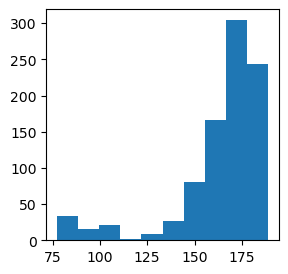

In [57]:
pert_osc = 0

# Stop time
time_stop_s   = 200
time_steps_s  = time_stop_s*sr
time_s        = linspace(start=0, stop=time_stop_s, num=time_steps_s)

resolution_freq, resolution_amp = 30, 30
# resolution_freq, resolution_amp = 30, 1

freq_min, freq_max = 0.1, 1.0

pulse_amplit_min, pulse_amplit_max = 0.1, 0.6

pulse_freqs  = linspace(freq_min, freq_max, resolution_freq)
pulse_amplis  = linspace(pulse_amplit_max, pulse_amplit_min, resolution_amp)

pulse_width   = 1

results_pert  = list()

results_max_f      = dict()
results_max_inds_f = dict()
results_min_f      = dict()
results_min_inds_f = dict()

for pulse in product(pulse_freqs, pulse_amplis):

    pulse = pulse[1]*ss.rect(mod(time_s, 1/pulse[0])-(1/pulse[0])/2-pulse_width/2, pulse_width)
    

    if pert_osc == 0:

        h_ex_p = h_ex_0        + pulse

    elif pert_osc == 1:

        h_ex_p = h_ex_0 - 0.1 + pulse
        
    elif pert_osc == 2:
        
        h_ex_p = h_ex_0 - 0.2 + pulse

    y = odeint(func=N_oscillators, y0=y_ini, t=time_s, args=(N, h_ex_rand, h_in_rand, 
                coupling_matrix, pars, flag, pert_osc, h_ex_p, sr, time_steps_s), hmax=0.1)

    rows = y.shape[0]

    # Collect integrals of transients
    results  = list()

    for col in arange(N):
        
        y_ex_positive = sqrt((y[rows//2:, 2*col]-y_ini[2*col])**2)

        results.append(sum(y_ex_positive) / sr)

    results_pert.append(results)

    
    for num, series in enumerate(y[rows//2:,:-1:2].T):
    
        # Collect extrema and their indices
        y_f_max_inds = signal.find_peaks(series, distance=100)
        y_f_maxs     = series[y_f_max_inds[0]]
    
        y_f_min_inds = signal.find_peaks(-series, distance=100)
        y_f_mins     = series[y_f_min_inds[0]]
    
        if num not in results_max_f:
    
            results_max_f[num]      = [y_f_maxs]
            results_max_inds_f[num] = [y_f_max_inds]
            results_min_f[num]      = [y_f_mins]    
            results_min_inds_f[num] = [y_f_min_inds]    
    
        else:
    
            results_max_f[num].append(y_f_maxs)
            results_max_inds_f[num].append(y_f_max_inds)
            results_min_f[num].append(y_f_mins)
            results_min_inds_f[num].append(y_f_min_inds)
    

results_pert_matrix = asarray(results_pert).reshape(resolution_freq, resolution_amp, N)

fig, ax = subplots(figsize=(3,3))

ax.hist(results_pert_matrix[:,:,pert_osc].ravel());

results_pert_matrix.shape

## Amplitude-Frequency Plot

'Figs/SNIC_pert_osc_0_coupling_1.0_scan_all_heatmap.png'

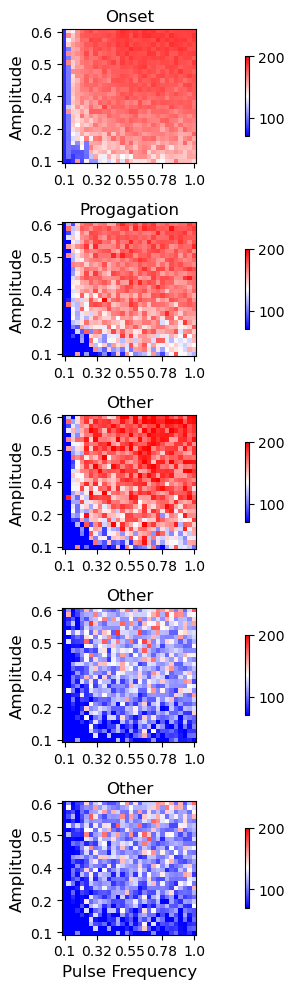

In [59]:
no_ticklabels = 5

vmin, vmax = min(results_pert_matrix), max(results_pert_matrix)
vmin, vmax = 70, 200

fig, ax = subplots(nrows=N, figsize=(10, 10))


if N == 1:
    
    im = ax.imshow(results_pert_matrix[:,:,0].T, cmap='bwr', vmin=vmin, vmax=vmax)

    fig.colorbar(im, ax=ax, shrink=0.6);

    label_chars = 'Onset Oscillator'

    ax.set_title(label_chars, fontsize=16)
    ax.set_ylabel('Pulse Amplitude', fontsize=16)
    ax.set_xticks(linspace(0, resolution_per-1, no_ticklabels))
    ax.set_xticklabels(around(linspace(pulse_period_min, pulse_period_max, no_ticklabels), 1))
    ax.set_yticks(linspace(0, resolution_amp-1, no_ticklabels))
    ax.set_yticklabels(around(linspace(pulse_amplit_min, pulse_amplit_max, no_ticklabels), 1))
    ax.set_xlabel('Pulse Width', fontsize=16)

else:

    for col in arange(N):
        
        im = ax[col].imshow(results_pert_matrix[:,:,col].T, cmap='bwr', vmin=vmin, vmax=vmax)

        fig.colorbar(im, ax=ax[col], shrink=0.6);

        # label_chars = 'Onset location

        if   col == 0:

            label_chars = 'Onset'

        elif col == 1:
            
            label_chars = 'Progagation'

        elif col == 2:
            
            label_chars = 'Other'
            

        ax[col].set_title(label_chars, fontsize=12)
        ax[col].set_ylabel('Amplitude', fontsize=12)
        ax[col].set_xticks(linspace(0, resolution_freq-1, no_ticklabels))
        ax[col].set_xticklabels(around(linspace(freq_min, freq_max, no_ticklabels), 2))
        ax[col].set_yticks(linspace(0, resolution_amp-1, no_ticklabels))
        ax[col].set_yticklabels(around(linspace(pulse_amplit_max, pulse_amplit_min, no_ticklabels), 1))

        if col == N-1:
            ax[col].set_xlabel('Pulse Frequency', fontsize=12)

fig.tight_layout()

title_chars = 'Figs/SNIC_pert_osc_' + str(pert_osc) + '_coupling_'+ str(coupling_strength) + '_scan_all_heatmap.png'
# fig.savefig(title_chars, format='png', transparent=False, dpi=300)

title_chars


## Scan Bifurcations (all oscillators)

In [60]:
if resolution_amp == 1:
    
    fig, ax = subplots(ncols=1, nrows=N, figsize=(8, 6))
    
    for osc in arange(N):
        
        # Forward
        for xe, ye in zip(pulse_freqs, results_max_f[osc]):
    
            if not isinstance(ye, ndarray):
                ax[osc].scatter(xe, ye, c='r', s=5)
            else:
                ax[osc].scatter([xe] * len(ye), ye, s=10, marker='o', facecolors='r')
    
        for xe, ye in zip(pulse_freqs, results_min_f[osc]):
    
            if not isinstance(ye, ndarray):
                ax[osc].scatter(xe, ye, c='b', s=5)
            else:
                ax[osc].scatter([xe] * len(ye), ye, s=10, marker='o', facecolors='b')

        # y_min, y_max = ax[osc].get_ylim()
        y_min, y_max = -5, 5
        ax[osc].set_ylim(y_min, y_max)

        ax[osc].set_yticks(linspace(y_min, y_max, 3));
        ax[osc].set_yticklabels(around(linspace(y_min, y_max, 3),1), fontsize=16);

        label_text = 'Osc ' + str(osc+1)
        ax[osc].set_ylabel(label_text, fontsize=14)

        ax[osc].set_xticks(linspace(pulse_freqs[0], pulse_freqs[-1], no_ticklabels));
        ax[osc].set_xticklabels(around(linspace(pulse_freqs[0], pulse_freqs[-1], no_ticklabels), 2), fontsize=16);

    ax[osc].set_xticks(linspace(pulse_freqs[0], pulse_freqs[-1], no_ticklabels));
    ax[osc].set_xticklabels(around(linspace(pulse_freqs[0], pulse_freqs[-1], no_ticklabels), 2), fontsize=16);
    ax[osc].set_xlabel('Frequency', fontsize=16)
    
    title_chars = 'Coupling Strength = ' + str(coupling_strength)
    fig.suptitle(title_chars, fontsize=16)
    
    fig.tight_layout()
    

title_chars = 'Figs/SNIC_pert_osc_' + str(pert_osc) + '_coupling_'+ str(coupling_strength) + '_scan_all_bifs.png'
# fig.savefig(title_chars, format='png')
title_chars


'Figs/SNIC_pert_osc_0_coupling_1.0_scan_all_bifs.png'

## Scan Bifurcations (single oscillator)

In [61]:
osc_plot = 0

if resolution_amp == 1:
    
    fig, ax = subplots(figsize=(6, 4))
            
    # Forward
    for xe, ye in zip(pulse_freqs, results_max_f[osc_plot]):

        if not isinstance(ye, ndarray):
            ax.scatter(xe, ye, c='r', s=5)
        else:
            ax.scatter([xe] * len(ye), ye, s=10, marker='o', facecolors='r')

    for xe, ye in zip(pulse_freqs, results_min_f[osc_plot]):

        if not isinstance(ye, ndarray):
            ax.scatter(xe, ye, c='b', s=5)
        else:
            ax.scatter([xe] * len(ye), ye, s=10, marker='o', facecolors='b')

    # y_min, y_max = ax[osc].get_ylim()
    y_min, y_max = -4, 4
    ax.set_ylim(y_min, y_max)

    ax.set_yticks(linspace(y_min, y_max, 3));
    ax.set_yticklabels(around(linspace(y_min, y_max, 3),1), fontsize=16);

    label_text = 'Osc ' + str(osc_plot+1)
    ax.set_ylabel(label_text, fontsize=14)

    ax.set_xticks(linspace(pulse_freqs[0], pulse_freqs[-1], 6));
    ax.set_xticklabels(around(linspace(pulse_freqs[0], pulse_freqs[-1], 6), 2), fontsize=16);
    ax.set_xlabel('Frequency', fontsize=16)
    
    title_chars = 'Coupling Strength = ' + str(coupling_strength)
    fig.suptitle(title_chars, fontsize=16)
    
    fig.tight_layout()
    
    
title_chars = 'Figs/SNIC_bifs_coup_' + str(coupling_strength) + '_osc_' + str(osc_plot) + '.png'
# fig.savefig(title_chars, format='png')
title_chars


'Figs/SNIC_bifs_coup_1.0_osc_0.png'

## Series with Periodic Perturbation

Freguency         Amplitude
0.5               0.5


'Figs/SNIC_pert_osc_0_coupling_1.0_freq_0.5_series.png'

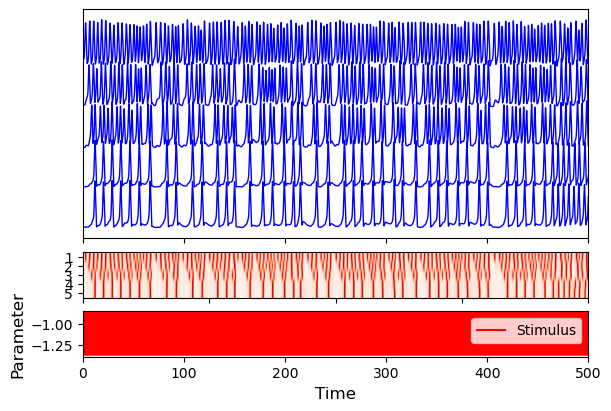

In [62]:
pert_matrix_maxima = zeros(3)

per_inds = list()

for index in arange(N):
    
    result = where(results_pert_matrix[:,:,index] == max(results_pert_matrix[:,:,index]))    
    per_inds.append([ind for ind in result])
    
print('Freguency         Amplitude')

best_stim_params = list()

for index in arange(N):
    best_stim_params.append((pulse_freqs[int(per_inds[index][0][0])], pulse_amplis[int(per_inds[index][1][0])]))

# Pulse protocol (other parameters as above)
pulse_freq      = 0.5
pulse_amplitude = 0.5

# pulse_freq, pulse_amplitude = best_stim_params[pert_osc][0], best_stim_params[pert_osc][1]

time_stop_s  = 500
time_steps_s = time_stop_s*sr
time_s       = linspace(start=0, stop=time_stop_s, num=time_steps_s)


if pert_osc == 0:

    pulse = pulse_amplitude*ss.rect(mod(time_s, 1/pulse_freq)-(1/pulse_freq)/2-pulse_width/2, pulse_width)
    
    h_ex_p = h_ex_0 + pulse

elif pert_osc == 1:

    pulse = pulse_amplitude*ss.rect(mod(time_s, 1/pulse_freq)-(1/pulse_freq)/2-pulse_width/2, pulse_width)
    
    h_ex_p = h_ex_0 + pulse - 0.1
    
elif pert_osc == 2:

    pulse = pulse_amplitude*ss.rect(mod(time_s, 1/pulse_freq)-(1/pulse_freq)/2-pulse_width/2, pulse_width)
    
    h_ex_p = h_ex_0 + pulse - 0.2


# Simulation
y_p = odeint(func=N_oscillators, y0=y_ini, t=time_s, args=(N, h_ex_rand, h_in_rand, 
            coupling_matrix, pars, flag, pert_osc, h_ex_p, sr, time_steps_s), hmax=0.1)

fig = figure(constrained_layout=True, figsize=(6,4))

gs  = fig.add_gridspec(7, 1)

ax1 = fig.add_subplot(gs[:5])

factor = 5.0

plot_data = y_p[:, ::2]

ax1.plot(time_s, plot_data - factor*arange(N), linewidth=1, c='b')
ax1.set_xticklabels([])
ax1.set_yticks([])
ax1.margins(x=0)

ax2 = fig.add_subplot(gs[6])

ax2.plot(time_s, h_ex_p, c='r', label='Stimulus')
ax2.legend()
ax2.set_ylabel('Parameter', fontsize=12)
ax2.margins(x=0)
ax2.set_xlabel('Time', fontsize=12)


ax3 = fig.add_subplot(gs[5])

ax3.imshow(plot_data.T, aspect='auto', cmap='Reds', interpolation='hermite', vmax=5);

ax3.set_yticks(arange(N))
ax3.set_yticklabels(arange(N)+1)
ax3.set_xticks(linspace(1, plot_data.shape[0], N))
ax3.set_xticklabels(linspace(-10, 50, N))

ax3.set_xticklabels([])

print(around(pulse_freq, 2), '             ', pulse_amplitude)

title_chars = 'Figs/SNIC_pert_osc_' + str(pert_osc) + '_coupling_'+ str(coupling_strength) + '_freq_' + str(pulse_freq) + '_series.png'

# fig.savefig(title_chars, format='png')
title_chars